<a href="https://colab.research.google.com/github/dajebbar/Flowers-Recognition-with-PyTorch/blob/main/Flowers_Recognition_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the dataset from kaggle
Using `opendatasets` and download the dataset [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition)

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

od.download(url)

  0%|          | 0.00/450M [00:00<?, ?B/s]

100%|██████████| 450M/450M [00:09<00:00, 50.8MB/s]


In [3]:
import os

data_dir = './flowers-recognition/flowers'

os.listdir(data_dir)

['sunflower', 'dandelion', 'rose', 'tulip', 'flowers', 'daisy']

In [4]:
import shutil

shutil.rmtree(data_dir + '/flowers')

In [5]:
os.listdir(data_dir)

['sunflower', 'dandelion', 'rose', 'tulip', 'daisy']

In [6]:
for cls in os.listdir(data_dir):
  print(f"{cls}: {len(os.listdir(data_dir + '/' + cls))}")

sunflower: 734
dandelion: 1055
rose: 784
tulip: 984
daisy: 769


## Import the dataset into PyTorch

Use the `ImageFolder` class from `torchvision`.

In [7]:
from torchvision.datasets import ImageFolder

In [8]:
dataset = ImageFolder(data_dir)

In [9]:
len(dataset)

4323

In [10]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F40635426D0>, 0)

In [11]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [12]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

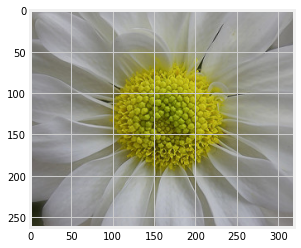

In [13]:
img, _ = dataset[0]
plt.imshow(img)

In [14]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

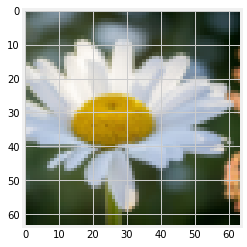

In [15]:
img, _ = dataset[170]
plt.imshow(img.permute(1,2,0))

In [16]:
val_pct = .1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3891, 432)

In [17]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(3891, 432)

In [18]:
from torch.utils.data import  DataLoader

batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=2, pin_memory=True)

val_dl = DataLoader(val_ds, batch_size,
                    num_workers=2, pin_memory=True)

In [19]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

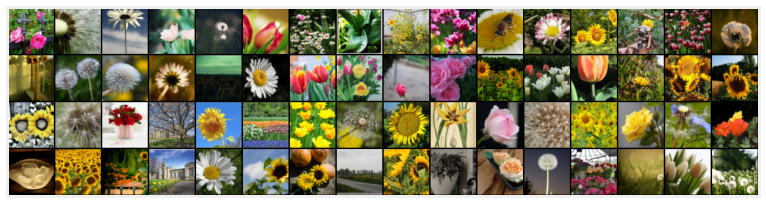

In [20]:
show_batch(train_dl)

## GPU Utilities

In [21]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cuda')

In [23]:
images, labels = dataset[0]

In [24]:
images.device

device(type='cpu')

In [25]:
img_gpu = to_device(images, device)
img_gpu.device

device(type='cuda', index=0)

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Model & Training Utilities

In [27]:
import torch.nn as nn
import torch.nn.functional as F


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [29]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [30]:
model = to_device(ResNet9(3, len(dataset.classes)), device)

model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [31]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model

In [32]:
torch.cuda.empty_cache()

for batch in train_dl:
  images, labels = batch
  print('images.shape ', images.shape)
  print('images.device ', images.device)

  preds = model(images)

  print('preds.shape ', preds.shape)
  print('preds ', preds)
  break

images.shape  torch.Size([64, 3, 64, 64])
images.device  cuda:0
preds.shape  torch.Size([64, 5])
preds  tensor([[-5.3602e-01, -1.1584e+00, -8.6042e-01, -3.0744e+00,  3.1406e+00],
        [-1.6394e+00, -2.3929e+00, -2.7388e+00,  2.6345e-01,  5.3570e+00],
        [ 7.7893e-01, -2.0579e+00,  5.1807e-01, -3.5843e-01,  2.4103e+00],
        [-1.9331e+00, -1.7323e+00, -5.1515e-01, -7.8385e-01,  2.5526e+00],
        [-1.4323e+00, -2.0325e+00, -5.2536e-01,  3.9105e-01,  1.2096e+00],
        [ 9.1456e-01, -4.7634e+00, -1.7904e+00, -1.4525e+00,  6.5923e+00],
        [-1.8604e+00, -1.8754e+00, -5.9846e-01, -8.1665e-01,  4.4537e+00],
        [-1.0496e+00, -2.0245e+00, -1.4822e+00, -1.2862e+00,  1.4767e+00],
        [-2.8271e+00, -4.6786e-01, -4.5135e+00,  1.9292e+00,  4.2656e+00],
        [-3.8010e-01, -6.3821e-01, -1.2730e+00, -2.4735e+00,  3.0332e+00],
        [-2.3611e+00, -3.6836e+00, -2.0488e+00, -7.5640e-01,  2.4333e+00],
        [-2.3380e+00, -3.9484e-01, -3.3280e+00, -1.5164e+00,  1.8795e+0

## Training

In [33]:
history = [evaluate(model, val_dl)]
history 

[{'val_acc': 0.1919642835855484, 'val_loss': 1.613505244255066}]

In [34]:
history += fit(5, 0.001,model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.3613, val_loss: 1.1154, val_acc: 0.5625
Epoch [1], train_loss: 1.0217, val_loss: 0.9543, val_acc: 0.6592
Epoch [2], train_loss: 0.8433, val_loss: 0.8730, val_acc: 0.6771
Epoch [3], train_loss: 0.7608, val_loss: 1.0645, val_acc: 0.6473
Epoch [4], train_loss: 0.7122, val_loss: 0.8673, val_acc: 0.6875


In [35]:
history += fit(5, 0.001,model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8289, val_loss: 0.7151, val_acc: 0.7396
Epoch [1], train_loss: 0.6488, val_loss: 0.6891, val_acc: 0.7530
Epoch [2], train_loss: 0.6322, val_loss: 0.8329, val_acc: 0.7262
Epoch [3], train_loss: 0.5546, val_loss: 0.9144, val_acc: 0.6830
Epoch [4], train_loss: 0.4752, val_loss: 0.4911, val_acc: 0.8080


In [36]:
history += fit(5, 0.0001,model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3468, val_loss: 0.4624, val_acc: 0.8534
Epoch [1], train_loss: 0.3067, val_loss: 0.4556, val_acc: 0.8408
Epoch [2], train_loss: 0.2963, val_loss: 0.4787, val_acc: 0.8356
Epoch [3], train_loss: 0.2703, val_loss: 0.4420, val_acc: 0.8445
Epoch [4], train_loss: 0.2698, val_loss: 0.4471, val_acc: 0.8445


In [37]:
history += fit(5, 0.001,model, train_dl, val_dl)

Epoch [0], train_loss: 0.2485, val_loss: 0.4565, val_acc: 0.8445
Epoch [1], train_loss: 0.2391, val_loss: 0.4341, val_acc: 0.8452
Epoch [2], train_loss: 0.2433, val_loss: 0.4505, val_acc: 0.8430
Epoch [3], train_loss: 0.2392, val_loss: 0.4425, val_acc: 0.8512
Epoch [4], train_loss: 0.2392, val_loss: 0.4439, val_acc: 0.8452


In [38]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

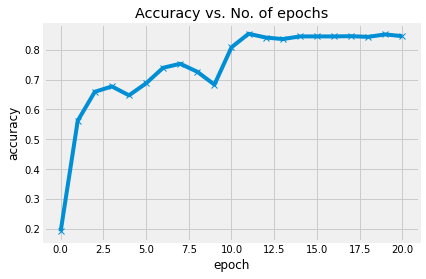

In [39]:
plot_accuracies(history)

In [40]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

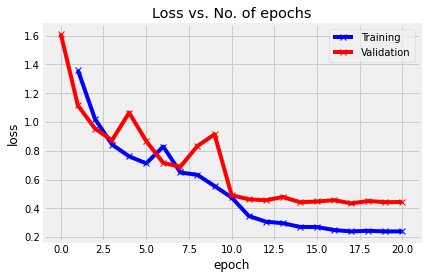

In [41]:
plot_losses(history)

## Test with individual images

In [43]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [58]:
def show_img(img, label):

  plt.imshow(img.permute(1,2,0))

  target = dataset.classes[label]
  pred = predict_image(img, model, dataset.classes)
  
  print('target label: ', target)
  print('predict label: ', pred)

target label:  sunflower
predict label:  sunflower


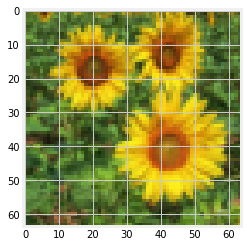

In [59]:
show_img(*val_ds[0])

target label:  rose
predict label:  tulip


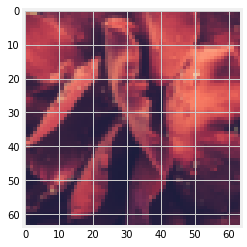

In [61]:
show_img(*val_ds[250])


target label:  daisy
predict label:  daisy


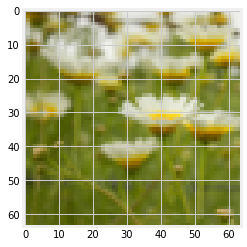

In [62]:
show_img(*val_ds[19])


target label:  dandelion
predict label:  dandelion


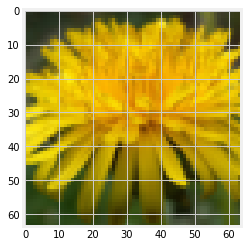

In [64]:
show_img(*val_ds[9])

target label:  dandelion
predict label:  sunflower


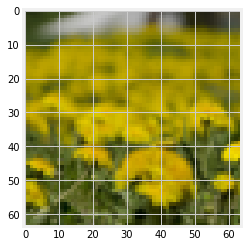

In [66]:
show_img(*val_ds[188])

target label:  tulip
predict label:  tulip


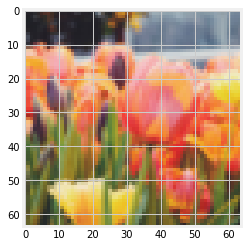

In [67]:
show_img(*val_ds[300])